# KTR Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite, KTR

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

In [3]:
orbit.__version__

'1.0.16dev'

## Data

In [4]:
df = load_iclaims()

DATE_COL = 'week'
RESPONSE_COL = 'claims'

print(df.shape)

df.head()

(443, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.21988,-0.31845,0.11750,-0.41763,0.12265
1,2010-01-10,13.62422,0.21988,-0.19484,0.16879,-0.42548,0.11044
2,2010-01-17,13.39874,0.23614,-0.29248,0.11750,-0.46523,0.53234
3,2010-01-24,13.13755,0.20335,-0.19484,0.10692,-0.48175,0.42864
4,2010-01-31,13.19676,0.13436,-0.24247,0.07448,-0.48893,0.48740


In [5]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2010-01-03 00:00:00
ends with 2018-06-24 00:00:00
shape: (443, 7)


In [6]:
test_size = 52

train_df = df[:-test_size]
test_df = df[-test_size:]

## KTR

### KTR - Full

In [11]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    seasonality_segments=3,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1,
    ktrlite_optim_args = dict()
)

In [12]:
ktr.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


In [13]:
ktr.get_regression_coefs().head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.09626,0.07596,0.18321
1,2010-01-10,0.09604,0.07599,0.18311
2,2010-01-17,0.09583,0.07602,0.18301
3,2010-01-24,0.09561,0.07604,0.18290
4,2010-01-31,0.09539,0.07607,0.18280


In [14]:
ktr.get_level_knots().head()

,week,lev_knot
0,2010-01-03,13.06327
1,2010-10-03,13.02754
2,2011-07-03,12.90772
3,2012-04-01,12.83349
4,2012-12-30,12.81371


In [15]:
ktr.get_regression_coef_knots().head()

,week,step,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0,0.10948,0.07499,0.18895
1,2011-07-03,78,0.06526,0.07645,0.17100
2,2012-12-30,156,0.08198,0.10201,0.16033
3,2014-06-29,234,0.07385,0.10634,0.11743
4,2015-12-27,312,0.05834,0.09899,0.14682


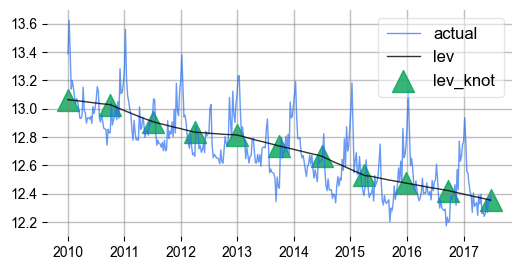

In [16]:
ktr.plot_lev_knots(figsize=(6, 3));

In [17]:
print(ktr._model._level_knot_dates)

['2010-01-03T00:00:00.000000000' '2010-10-03T00:00:00.000000000'
 '2011-07-03T00:00:00.000000000' '2012-04-01T00:00:00.000000000'
 '2012-12-30T00:00:00.000000000' '2013-09-29T00:00:00.000000000'
 '2014-06-29T00:00:00.000000000' '2015-03-29T00:00:00.000000000'
 '2015-12-27T00:00:00.000000000' '2016-09-25T00:00:00.000000000'
 '2017-06-25T00:00:00.000000000']


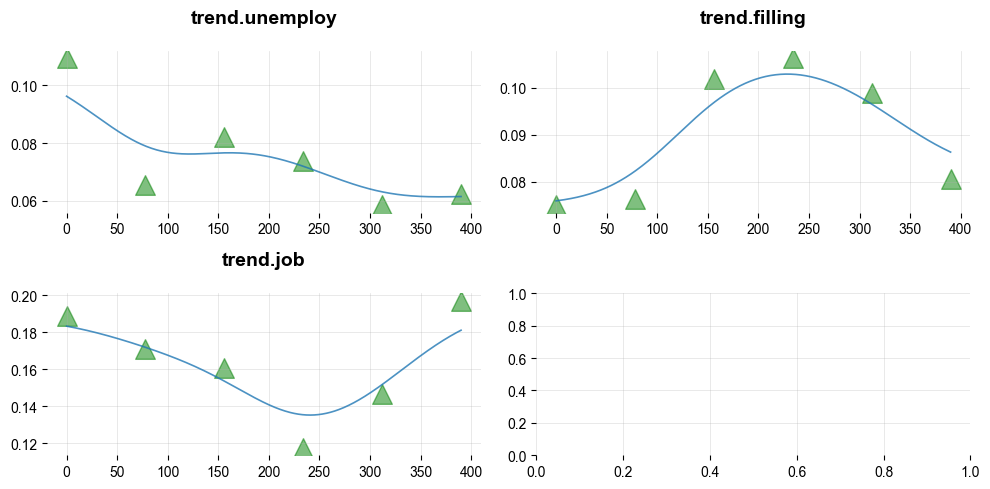

In [18]:
ktr.plot_regression_coefs(with_knot=True, figsize=(10, 5), include_ci=False);

In [19]:
ktr._model._regression_knot_dates

array(['2010-01-03T00:00:00.000000000', '2011-07-03T00:00:00.000000000',
       '2012-12-30T00:00:00.000000000', '2014-06-29T00:00:00.000000000',
       '2015-12-27T00:00:00.000000000', '2017-06-25T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [20]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_input_5,seasonality_input,seasonality_input_95,regression_5,regression,regression_95
0,2017-07-02,11.86003,12.33685,12.81777,12.24653,12.35295,12.44579,-0.01455,-0.01455,-0.01455,-0.02987,0.00939,0.04893
1,2017-07-09,11.92065,12.36073,12.80581,12.24504,12.35263,12.44647,-0.02259,-0.02259,-0.02259,-0.01213,0.02347,0.06007
2,2017-07-16,11.88946,12.32265,12.79390,12.24545,12.35287,12.44591,-0.03450,-0.03450,-0.03450,-0.01152,0.01674,0.04675
3,2017-07-23,11.83762,12.31617,12.76196,12.24383,12.35250,12.44600,-0.05014,-0.05014,-0.05014,-0.00661,0.01894,0.04559
4,2017-07-30,11.83771,12.30253,12.76115,12.24251,12.35280,12.44638,-0.06903,-0.06903,-0.06903,-0.00774,0.02576,0.06004


In [21]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.76%'

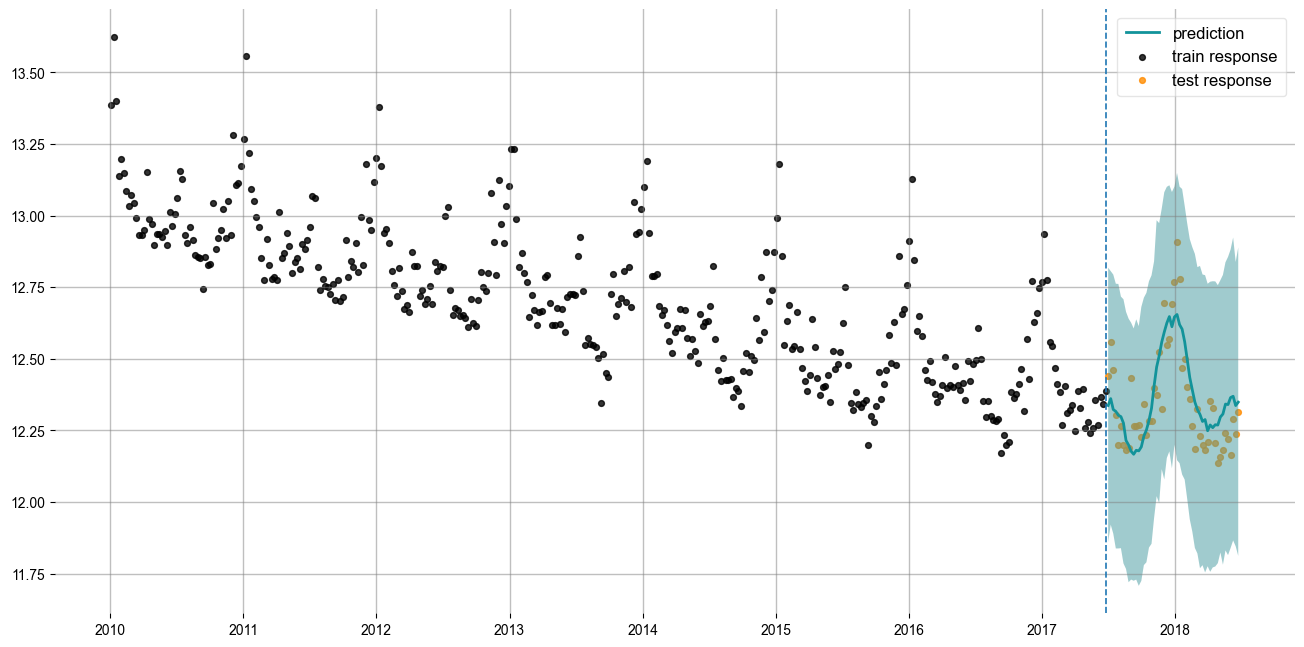

In [22]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

### KTR - Median

INFO:root:Guessed max_plate_nesting = 1


SMAPE: 0.78%


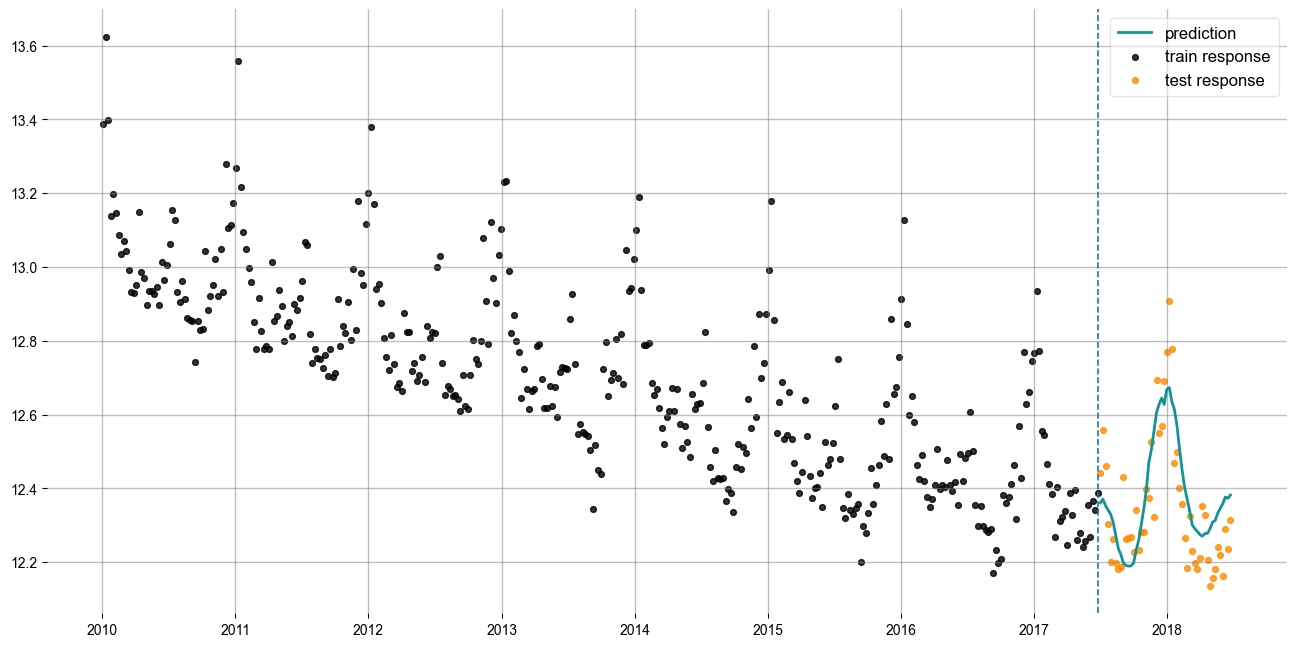

In [23]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    seasonality_segments=2,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

ktr.fit(df=train_df, point_method='median')
ktr.get_regression_coefs().head()

predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

print(f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}")

_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)



## Electricity data (dual seasoanlity, no regressor)

In [24]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

df['electricity'] = np.log(df['electricity'])

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [25]:
test_size = 365

train_df = df[:-test_size]
test_df = df[-test_size:]

In [26]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=20,
    seasonality_segments=3,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

In [27]:
ktr.fit(df=train_df, point_method='median')

INFO:root:Guessed max_plate_nesting = 1


In [28]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

,date,prediction,trend,seasonality_input,regression
360,2008-12-27,9.93740,9.97551,-0.03811,0.00000
361,2008-12-28,9.88227,9.97551,-0.09324,0.00000
362,2008-12-29,9.94680,9.97551,-0.02871,0.00000
363,2008-12-30,10.00829,9.97551,0.03278,0.00000
364,2008-12-31,9.98963,9.97551,0.01412,0.00000


In [29]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.60%'

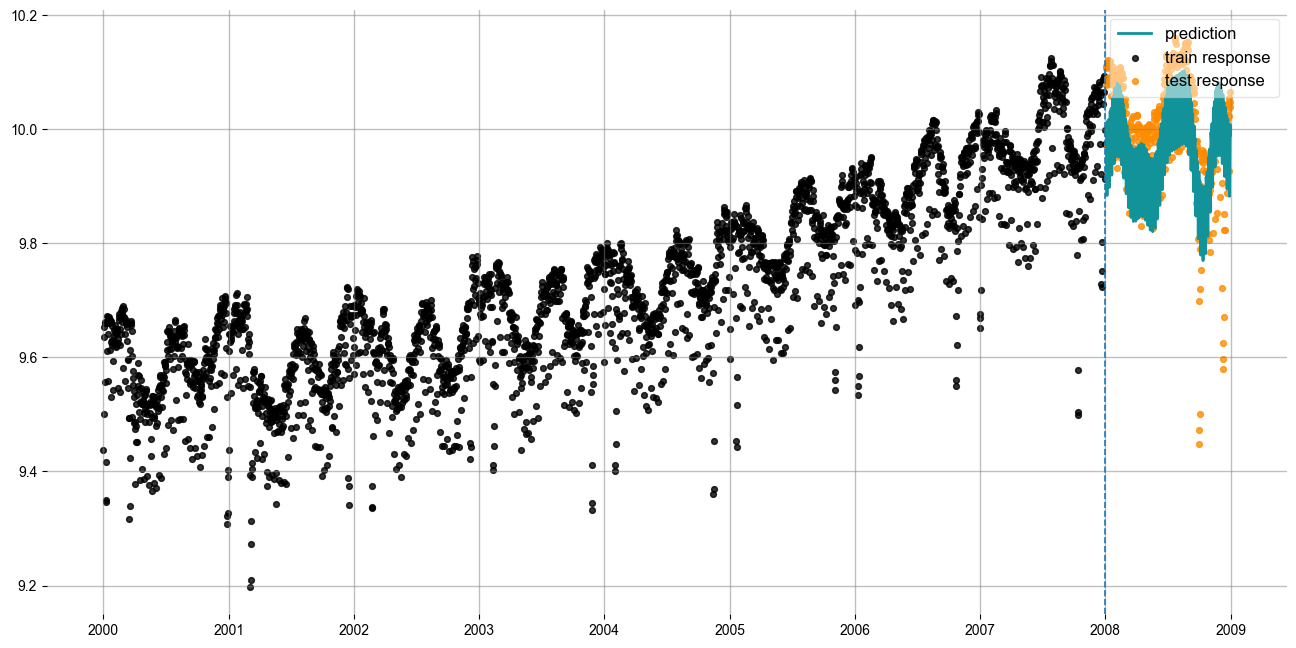

In [30]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)